In [23]:
from scipy.sparse import csgraph
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

from math import floor

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import svm

from sklearn.svm import OneClassSVM 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import read_csv
from datetime import datetime

from matplotlib import pyplot as plt
%matplotlib inline

import keras


from numpy import array

from keras.models import Sequential
from keras.layers import LSTM

from keras.layers import Dense
from keras.layers import RepeatVector

from keras.layers import TimeDistributed
from keras.layers import Dropout

from keras.utils import plot_model
import pydot_ng as pydot

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K

from keras.utils import plot_model

In [25]:
# Load training data set from CSV file
dataset = pd.read_csv("shuttle-unsupervised-ad.tab", sep = '\t', header =None)
dataset


0    1      2    3     4     5     6      7      8  9
0      108.0  3.0  109.0  0.0  72.0   7.0   1.0   36.0   36.0  o
1       81.0  0.0   84.0  0.0 -14.0  -2.0   4.0  100.0   96.0  o
2       81.0  0.0   84.0  0.0 -20.0  16.0   4.0  105.0  102.0  o
3       76.0 -1.0   81.0  0.0 -42.0  -3.0   5.0  125.0  120.0  o
4      105.0  0.0  107.0  2.0  70.0   0.0   1.0   37.0   36.0  o
...      ...  ...    ...  ...   ...   ...   ...    ...    ... ..
46459   46.0  5.0   78.0  0.0  46.0   5.0  32.0   32.0    0.0  n
46460   37.0  0.0   79.0 -1.0  10.0   3.0  43.0   69.0   26.0  n
46461   48.0  0.0   78.0  3.0  46.0   0.0  30.0   32.0    2.0  n
46462   41.0  0.0   79.0  0.0  38.0 -25.0  38.0   40.0    2.0  n
46463   40.0 -3.0  100.0  0.0  38.0   0.0  61.0   62.0    2.0  n

[46464 rows x 10 columns]

In [26]:
dataset =  dataset.iloc[:,0:9]
dataset

0    1      2    3     4     5     6      7      8
0      108.0  3.0  109.0  0.0  72.0   7.0   1.0   36.0   36.0
1       81.0  0.0   84.0  0.0 -14.0  -2.0   4.0  100.0   96.0
2       81.0  0.0   84.0  0.0 -20.0  16.0   4.0  105.0  102.0
3       76.0 -1.0   81.0  0.0 -42.0  -3.0   5.0  125.0  120.0
4      105.0  0.0  107.0  2.0  70.0   0.0   1.0   37.0   36.0
...      ...  ...    ...  ...   ...   ...   ...    ...    ...
46459   46.0  5.0   78.0  0.0  46.0   5.0  32.0   32.0    0.0
46460   37.0  0.0   79.0 -1.0  10.0   3.0  43.0   69.0   26.0
46461   48.0  0.0   78.0  3.0  46.0   0.0  30.0   32.0    2.0
46462   41.0  0.0   79.0  0.0  38.0 -25.0  38.0   40.0    2.0
46463   40.0 -3.0  100.0  0.0  38.0   0.0  61.0   62.0    2.0

[46464 rows x 9 columns]

In [27]:
values =dataset.values

In [28]:
values.shape

(46464, 9)

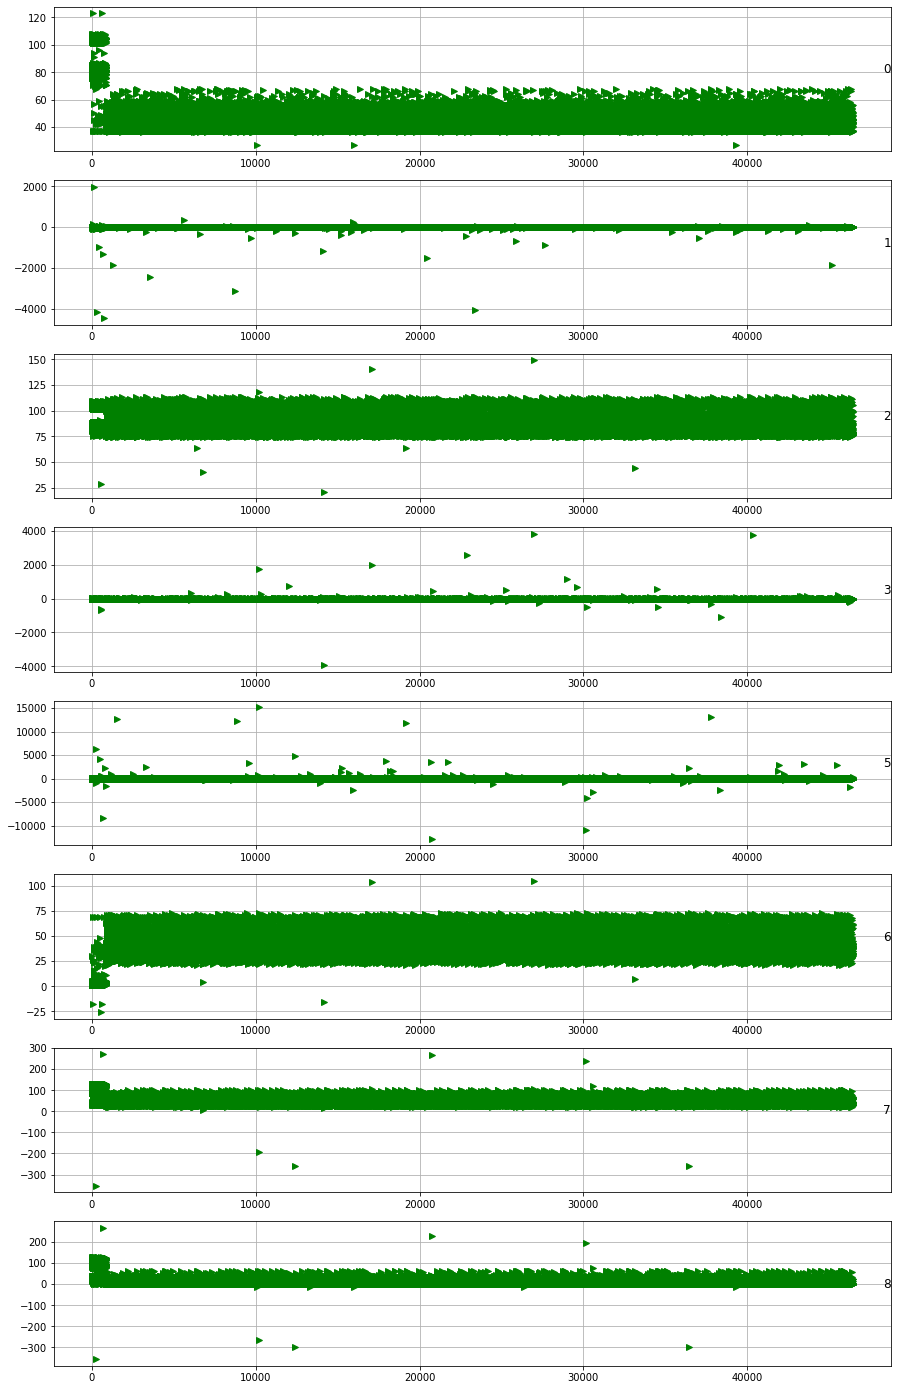

In [29]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8]
i = 1
# plot each column
fig1 = plt.figure(figsize=(15,25))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group] , 'g>')
    plt.title(dataset.columns[group], y=0.5, loc='right')
    plt.grid()
    i += 1

plt.show()

In [30]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [31]:
##Data preparation

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)


print('**********************************************************************************************')
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.head())

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.843750   0.695558   0.687500   0.507015   0.416667   0.458156   
2       0.562500   0.695092   0.492188   0.507015   0.278846   0.457834   
3       0.562500   0.695092   0.492188   0.507015   0.269231   0.458478   
4       0.510417   0.694936   0.468750   0.507015   0.233974   0.457799   
5       0.812500   0.695092   0.671875   0.507272   0.413462   0.457906   
...          ...        ...        ...        ...        ...        ...   
46459   0.187500   0.694315   0.539062   0.507015   0.371795   0.456976   
46460   0.197917   0.695868   0.445312   0.507015   0.375000   0.458085   
46461   0.104167   0.695092   0.453125   0.506886   0.317308   0.458013   
46462   0.218750   0.695092   0.445312   0.507401   0.375000   0.457906   
46463   0.145833   0.695092   0.453125   0.507015   0.362179   0.457012   

       var7(t-1)  var8(t-1)  var9(t-1)   var1(t)   var2(t)   var3(t)  \
1       0.206107   0.624398

In [32]:
# split into train and test sets
values = reframed.values
n_train_msec = floor(len(dataset)*0.8)
train = values[:n_train_msec, :]
test = values[n_train_msec:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(37171, 1, 8) (37171,) (9292, 1, 8) (9292,)


In [73]:
#Model
sdae_encoder =Sequential([
keras.layers.Input(shape= (train_X.shape[1], train_X.shape[2])) ,
keras.layers.Dropout(0.5),
keras.layers.LSTM(100),
keras.layers.Dense(24)
])

sdae_decoder = Sequential([
keras.layers.Input(shape=[24]),
keras.layers.RepeatVector(n=train_X.shape[1]),
keras.layers.TimeDistributed(Dense(8))
])

# sdae = keras.models.Sequential([sdae_encoder, sdae_decoder])
sdae =Sequential([sdae_encoder, sdae_decoder])

In [74]:
sdae.compile(loss="binary_crossentropy",
optimizer=keras.optimizers.SGD(lr=1.5))

In [75]:
# fit network
history = sdae.fit(train_X, train_X, epochs=5, batch_size=600, verbose=1, shuffle=False)

Epoch 1/5
62/62 [==============================] - 0s 3ms/step - loss: 6.6684
Epoch 2/5
62/62 [==============================] - 0s 3ms/step - loss: 6.7157
Epoch 3/5
62/62 [==============================] - 0s 3ms/step - loss: 6.7157
Epoch 4/5
62/62 [==============================] - 0s 3ms/step - loss: 6.7157
Epoch 5/5
62/62 [==============================] - 0s 3ms/step - loss: 6.7157


In [76]:
yhat= sdae.predict(train_X)

In [77]:
yhat.shape

(37171, 1, 8)

In [78]:
x= []
for i in range(0,yhat.shape[0]):
   x.append(yhat[i,0])

data_decoded = np.array(x)

In [79]:
data_decoded.shape

(37171, 8)

In [80]:
xx= []
for i in range(0,train_X.shape[0]):
   xx.append(train_X[i,0])


original = np.array(xx)

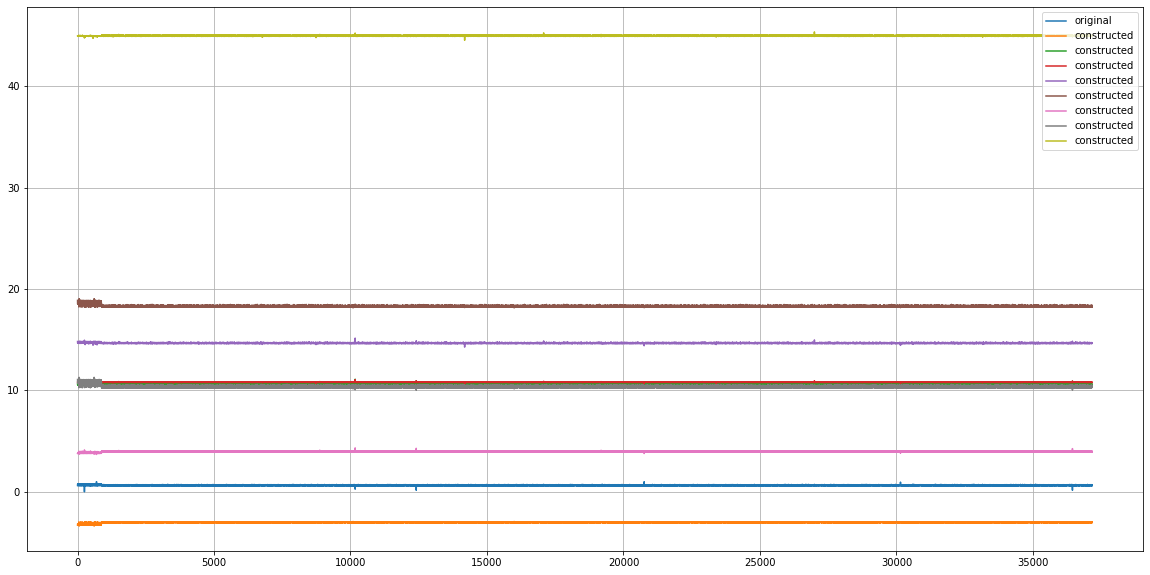

In [81]:
figure1 = plt.figure(figsize=(20,10))
plt.plot(original[:,7], label ='original' )
plt.plot(data_decoded, label = 'constructed')
plt.legend()
plt.grid()
plt.show()